In [1]:
import os
import cv2
import torch
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam

In [2]:
def extract_and_save_frames(dataset_path, output_base_dir, frame_count=30):
    categories = ['Normal', 'Violence']  # Exclude 'Weaponized'
    phases = ['Train', 'Test']
    for phase in phases:
        for category in categories:
            video_dir = os.path.join(dataset_path, phase, category)
            output_dir = os.path.join(output_base_dir, phase, category)
            os.makedirs(output_dir, exist_ok=True)
            videos = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith('.avi')]
            for video_path in videos:
                video_basename = os.path.splitext(os.path.basename(video_path))[0]
                video_frame_dir = os.path.join(output_dir, video_basename)
                os.makedirs(video_frame_dir, exist_ok=True)
                video = cv2.VideoCapture(video_path)
                count = 0
                try:
                    while count < frame_count:
                        ret, frame = video.read()
                        if not ret:
                            break
                        frame = cv2.resize(frame, (224, 224))
                        frame_filename = f"{video_frame_dir}/{count}.png"
                        cv2.imwrite(frame_filename, frame)
                        count += 1
                finally:
                    video.release()


In [3]:
# Setup paths and directories
#Run it once
# dataset_base_path = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\SCVD - Copy\SCVD_converted'
# output_base_dir = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\out'
# extract_and_save_frames(dataset_base_path, output_base_dir)

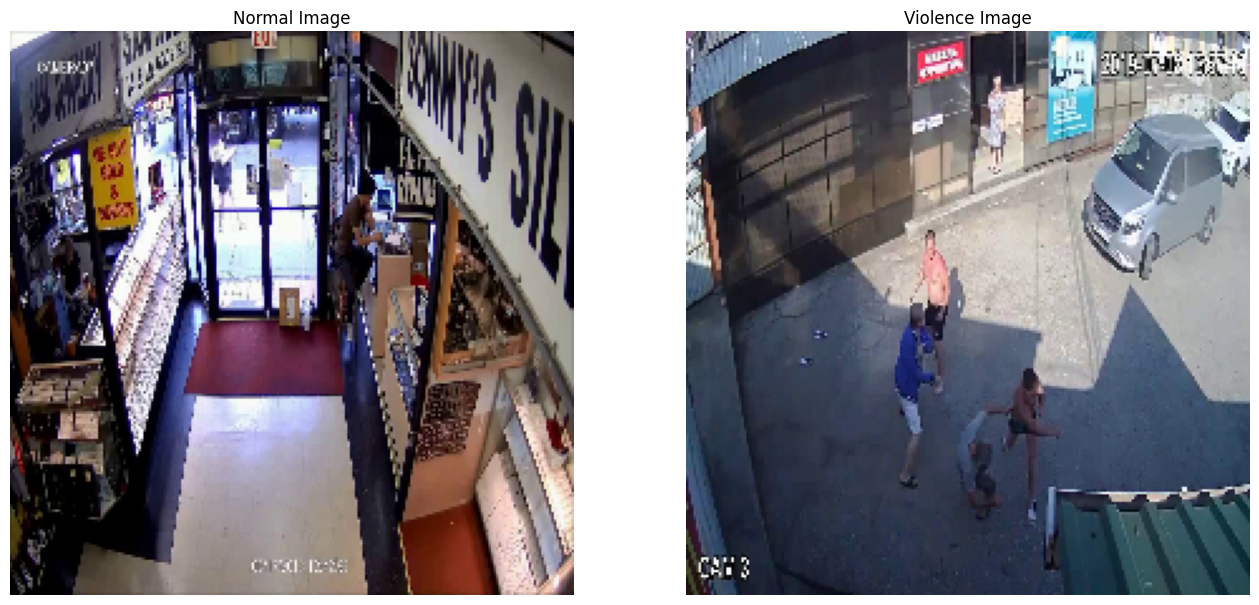

In [4]:
# Load the images
Normal_image = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\out\Train\Normal\t_n003_converted\10.png'
Violence_image = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\out\Test\Violence\v003_converted\4.png'

# Read and convert the Normal image
Normal_frame = cv2.imread(Normal_image)
Normal_rgb = cv2.cvtColor(Normal_frame, cv2.COLOR_BGR2RGB)

# Read and convert the Violence image
Violence_frame = cv2.imread(Violence_image)
Violence_rgb = cv2.cvtColor(Violence_frame, cv2.COLOR_BGR2RGB)

# Display the images side by side
plt.figure(figsize=(16, 8))

# Show the Normal image
plt.subplot(1, 2, 1)
plt.imshow(Normal_rgb)
plt.title("Normal Image")
plt.axis('off')

# Show the Violence image
plt.subplot(1, 2, 2)
plt.imshow(Violence_rgb)
plt.title("Violence Image")
plt.axis('off')

plt.show()

In [5]:
def enhance_image(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply histogram equalization for contrast enhancement
    enhanced_image = cv2.equalizeHist(gray_image)
    return enhanced_image

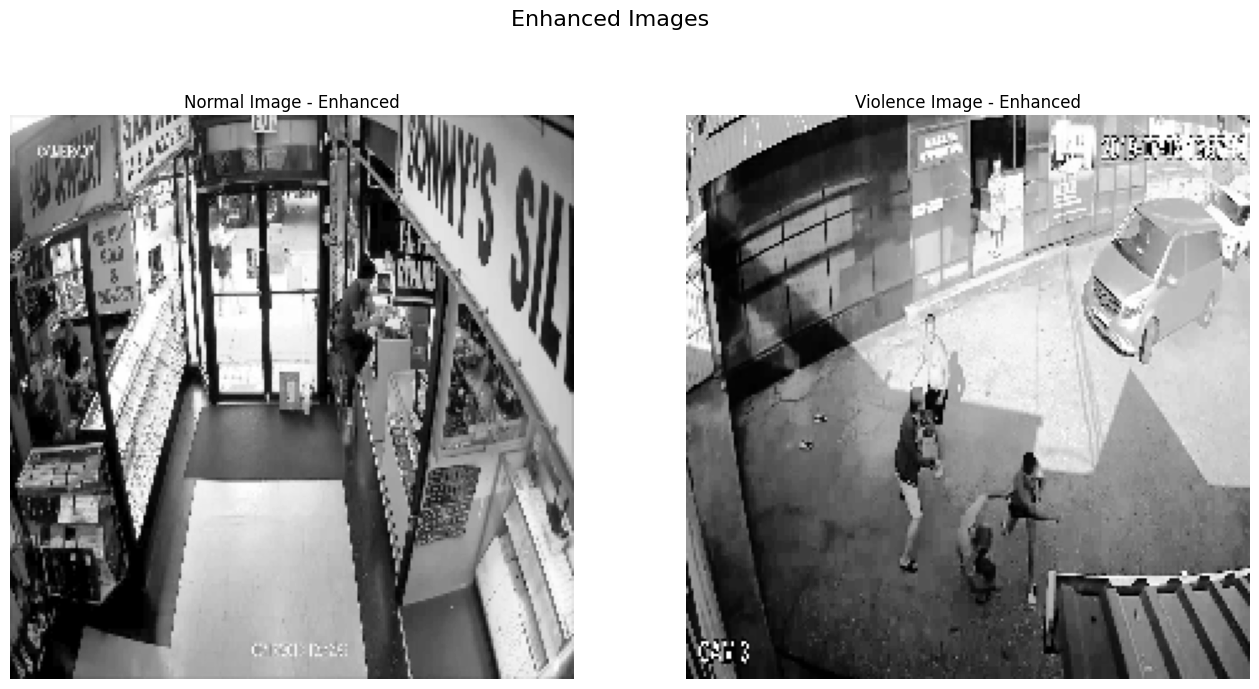

In [6]:
# Enhance images
Normal_enhanced = enhance_image(Normal_frame)
Violence_enhanced = enhance_image(Violence_frame)
# Display Enhanced Images
plt.figure(figsize=(16, 8))
plt.suptitle("Enhanced Images", fontsize=16)

plt.subplot(1, 2, 1)
plt.imshow(Normal_enhanced, cmap='gray')
plt.title("Normal Image - Enhanced")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Violence_enhanced, cmap='gray')
plt.title("Violence Image - Enhanced")
plt.axis('off')

plt.show()

In [7]:
# Load the pretrained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # You can use 'yolov5m', 'yolov5l', 'yolov5x' for higher accuracy
# Directory to save segmented images
save_dir = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\SegmentedImages'
os.makedirs(save_dir, exist_ok=True)

Using cache found in C:\Users\malak/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-12-20 Python-3.11.9 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [8]:
# Segment image using YOLO and display in plot
def segment_with_yolo(image, model):
    # Perform object detection
    results = model(image)
    
    # Extract bounding boxes, labels, and confidences
    boxes = results.xyxy[0].numpy()  # Bounding box coordinates
    labels = results.names  # Object labels (e.g., person, knife, etc.)
    
    # Convert the image to RGB (YOLO expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Filter for people (class 0) and weapons (class labels might vary depending on the model)
    people_class_id = 0  # 'person' class in YOLO
    weapon_class_ids = [39, 40]  # Example class IDs for 'knife', 'gun' (check YOLO class IDs)
    
    # Create a mask for people and weapons
    mask = np.zeros_like(image_rgb)
    for box in boxes:
        class_id = int(box[5])  # Class ID from the results
        if class_id == people_class_id or class_id in weapon_class_ids:
            x1, y1, x2, y2 = map(int, box[:4])
            mask[y1:y2, x1:x2] = image_rgb[y1:y2, x1:x2]  # Segment the region
    
    return mask

In [9]:
# File paths for the segmented images
Normal_segmented_path = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\SegmentedImages\normal_segmented.png'
Violence_segmented_path = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\SegmentedImages\violence_segmented.png'

# Load the segmented images
Normal_segmented = cv2.imread(Normal_segmented_path)
Violence_segmented = cv2.imread(Violence_segmented_path)

# Check if the images are non-empty (not all zeros)
if Normal_segmented is not None and not Normal_segmented.any():
    print("Warning: Normal image is empty (all zeros).")
if Violence_segmented is not None and not Violence_segmented.any():
    print("Warning: Violence image is empty (all zeros).")

# Convert the images from BGR to RGB (OpenCV loads images in BGR format)
if Normal_segmented is not None:
    Normal_segmented_rgb = cv2.cvtColor(Normal_segmented, cv2.COLOR_BGR2RGB)
if Violence_segmented is not None:
    Violence_segmented_rgb = cv2.cvtColor(Violence_segmented, cv2.COLOR_BGR2RGB)

# Test displaying images directly using OpenCV
if Normal_segmented is not None:
    cv2.imshow("Normal Image - Segmented", Normal_segmented)
if Violence_segmented is not None:
    cv2.imshow("Violence Image - Segmented", Violence_segmented)

# Wait for a key press and close the OpenCV window
cv2.waitKey(0)
cv2.destroyAllWindows()

# Display segmented images in a plot (Matplotlib)
plt.figure(figsize=(16, 8))
plt.suptitle("Segmented Images", fontsize=16)

# Display Normal Image - Segmented
if Normal_segmented is not None:
    plt.subplot(1, 2, 1)
    plt.imshow(Normal_segmented_rgb)
    plt.title("Normal Image - Segmented")
    plt.axis('off')

# Display Violence Image - Segmented
if Violence_segmented is not None:
    plt.subplot(1, 2, 2)
    plt.imshow(Violence_segmented_rgb)
    plt.title("Violence Image - Segmented")
    plt.axis('off')

plt.show()

In [10]:
# Base directory where all video frame folders are stored
base_video_dir = r"C:\Users\malak\OneDrive\Documents\Image Processing Project\out\Train"

In [13]:
# Function to process and display frames from all video folders
def process_frames_from_video_folders(base_dir, label):
    # Get all subfolders (video folders) under Normal and Violence directories
    video_categories = ['Normal', 'Violence']
    
    for category in video_categories:
        category_path = os.path.join(base_dir, category)
        
        # Check if category exists
        if not os.path.exists(category_path):
            print(f"{category} directory does not exist: {category_path}. Skipping this category.")
            continue
        
        # Get all subfolders (specific video folders) under each category
        video_folders = [f for f in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, f))]

        if len(video_folders) == 0:
            print(f"No video folders found in {category_path}. Skipping this category.")
            continue
        
        for video_folder in video_folders:
            video_folder_path = os.path.join(category_path, video_folder)
            
            # Get all image files (frames) in the current video folder
            image_files = [f for f in os.listdir(video_folder_path) if f.endswith('.png')]  # Assuming frames are PNG
            
            if len(image_files) == 0:
                print(f"No frames found in {video_folder}. Skipping this folder.")
                continue
            
            for image_file in image_files:
                image_path = os.path.join(video_folder_path, image_file)
                
                # Read and process the image
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error reading {image_file}. Skipping this file.")
                    continue
                
                # Convert to RGB for displaying with matplotlib
                rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Apply enhancement and segmentation
                enhanced_image = enhance_image(image)
                segmented_image = segment_with_yolo(enhanced_image, model)

In [14]:
# Check if the base directory exists
if not os.path.exists(base_video_dir):
    print(f"The base directory does not exist: {base_video_dir}. Please check the path.")
else:
    # Process frames from all Normal video folders
    process_frames_from_video_folders(base_video_dir, 'Normal')

    # Process frames from all Violence video folders
    process_frames_from_video_folders(base_video_dir, 'Violence')

C:\Users\malak/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\malak/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\malak/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\malak/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\malak/.cache\torch\hub\ultralytics_yolov5_master\models

In [15]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim

In [16]:
# Define dataset paths
train_dir = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\out\Train'

In [18]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [19]:
# Load the dataset
train_dataset = ImageFolder(train_dir, transform=transform)

In [20]:
# Split into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [21]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [22]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Input: 3x224x224, Output: 32x224x224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 32x112x112

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 64x112x112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 64x56x56

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# Output: 128x56x56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # Output: 128x28x28
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                         # Flatten the output of conv layers
            nn.Linear(128 * 28 * 28, 256),                       # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),                                     # Dropout for regularization
            nn.Linear(256, 2)                                    # Output layer for 2 classes (binary classification)
        )

    def forward(self, x):
        # Pass the input through the convolutional layers
        x = self.conv_layers(x)
        # Pass the output through the fully connected layers
        x = self.fc_layers(x)
        return x


In [23]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# Training loop
for epoch in range(10):  # Set number of epochs
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.050751785346932365
Epoch 2, Loss: 0.00019683268013181987
Epoch 3, Loss: 0.001468692750314915
Epoch 4, Loss: 0.10281749927478145
Epoch 5, Loss: 0.015760290663081378
Epoch 6, Loss: 0.00015907492581845872
Epoch 7, Loss: 0.00023583774606095176
Epoch 8, Loss: 3.668047247629147e-05
Epoch 9, Loss: 0.00013257747707484668
Epoch 10, Loss: 2.4058355108991236e-05


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Track validation loss and accuracy
val_losses = []
val_accuracies = []

# Validation loop
model.eval()
val_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Collect predictions and labels for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate average loss and accuracy
avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct / total
val_losses.append(avg_val_loss)
val_accuracies.append(val_accuracy)

print(f"Validation Loss: {avg_val_loss}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 6.2518715822079685e-06
Validation Accuracy: 100.00%


In [32]:
# Plot Validation Loss and Accuracy
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Violence'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Save the trained model
torch.save(model.state_dict(), 'violence_detection_model.pth')